In [25]:
import sys
sys.path.append('/home/wangs/rs/lib')
import ff
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
sns.set_palette("pastel")
from multiprocessing import Pool
from tqdm import tqdm

In [2]:
##第一种分类方法
def class_1(daily_minute_df):
    daily_minute_df['return_direction'] = np.sign(daily_minute_df['minute_return'])

    # 1. 处理持平状态：将持平(0)的方向填充为前一个非零方向
    # 创建一个辅助列，仅包含非零方向值
    non_zero_direction = daily_minute_df['return_direction'].replace(0, np.nan)
    # 向前填充持平值，使其归属于前一个非持平趋势
    daily_minute_df['filled_direction'] = non_zero_direction.ffill().fillna(0)

    # 2. 识别趋势转折点（仅在非持平→非持平且方向变化时标记）
    daily_minute_df['trend_change'] = daily_minute_df['filled_direction'].diff().abs() > 0

    # 3. 为每个趋势段分配唯一ID
    daily_minute_df['trend_id'] = daily_minute_df['trend_change'].cumsum()

    # 4. 计算每个趋势段的最后一分钟成交量，并移到下一个趋势段
    last_volume = daily_minute_df.groupby('trend_id')['volume'].last().shift(1)
    last_volume.name = 'last_segment_volume'

    # 5. 将上一趋势段的最后成交量合并回原始DataFrame
    daily_minute_df = daily_minute_df.merge(
        last_volume.reset_index(), 
        on='trend_id', 
        how='left'
    )


    # 6. 根据当前成交量与上一趋势段最后成交量的比较，分类为放量或缩量
    daily_minute_df['class_1'] = np.where(
        daily_minute_df['volume'] > daily_minute_df['last_segment_volume'],
        '放量',
        np.where(daily_minute_df['volume'] < daily_minute_df['last_segment_volume'], '缩量', np.NaN)
    )

    # 7. 根据填充后的方向分类价格趋势
    daily_minute_df['price_class'] = np.where(
        daily_minute_df['filled_direction'] > 0, '上涨',
        np.where(daily_minute_df['filled_direction'] < 0, '下跌', np.NaN)
    )

    daily_minute_df.drop(columns=['return_direction', 'filled_direction','trend_change','last_segment_volume'], inplace=True)
    daily_minute_df['class_1'] = daily_minute_df['class_1'] + daily_minute_df['price_class']
    return daily_minute_df

In [3]:
##第二种分类方法

def class_2(df):
    result = pd.Series(np.nan, index=df.index,name = 'class_2')
    if len(df) == 1:
        return result
    V = df['volume']
    V_min = V_max = V.iloc[0]
    for i in range(1,len(df)):
        if V.iloc[i] > V_max:
            result.iloc[i] = '放量'
            V_max = V.iloc[i]
        elif V.iloc[i] < V_min:
            result.iloc[i] = '缩量'
            V_min = V.iloc[i]
        else:
            result.iloc[i] = '平量'
    return result

In [11]:
##计算各形态的日内收益率

def daily_return_calculate(df):
    class_1_return = pd.Series(0,index = ['放量上涨','缩量上涨','放量下跌','缩量下跌'])
    class_2_return = pd.Series(0,index=  ['放量持续上涨','平量持续上涨','缩量持续上涨','放量持续下跌','平量持续下跌','缩量持续下跌'])
    for name, group in df.groupby('class_1')['minute_return']:
        if name in class_1_return.index:
            # 累乘 (1+收益率)，再减1得到总收益率
            class_1_return[name] = (group + 1).prod() - 1
    for name, group in df.groupby('class_2')['minute_return']:
        if name in class_2_return.index:
            # 累乘 (1+收益率)，再减1得到总收益率
            class_2_return[name] = (group + 1).prod() - 1      
    return class_1_return,class_2_return

In [18]:
def class_ret(stock_id):
    try:
        minute_df = ff.read_min(stock_id)
    except:
        return stock_id,pd.DataFrame(columns = ['放量上涨','缩量上涨','放量下跌','缩量下跌','放量持续上涨','平量持续上涨','缩量持续上涨','放量持续下跌','平量持续下跌','缩量持续下跌'])
    minute_df.index.name = 'time'
    minute_df.index = pd.to_datetime(minute_df.index)
    datelist = minute_df.index.strftime('%Y-%m-%d').unique()
    merge_df = pd.DataFrame(index=datelist,
                            columns = ['放量上涨','缩量上涨','放量下跌','缩量下跌','放量持续上涨','平量持续上涨','缩量持续上涨','放量持续下跌','平量持续下跌','缩量持续下跌'])


        ##计算各形态日间收益率

    for date in datelist:
        try:
            daily_minute_df = minute_df.loc[date]
            daily_minute_df['minute_return'] = daily_minute_df['close'].pct_change()

            daily_minute_df = class_1(daily_minute_df)
            daily_minute_df['class_2'] = daily_minute_df.groupby('trend_id').apply(class_2).reset_index(level=0, drop=True)
            daily_minute_df['class_2'] = daily_minute_df['class_2'] + '持续' + daily_minute_df['price_class']

            return1, return2 = daily_return_calculate(daily_minute_df)
            merge_df.loc[date] = pd.concat([return1,return2])
        except Exception as e:
                #print(f"处理日期 {date} 时出错: {e}")
            continue
    return stock_id,merge_df

In [36]:
def ret_for_stock(max_workers = 16):
    stock_list = ff.cl
    long_table_list = []
    with Pool(processes=max_workers) as pool:
        # 使用tqdm显示进度条
        for stock_id, stock_result in tqdm(
            pool.imap_unordered(class_ret, stock_list), 
            total=len(stock_list), 
            desc="处理进度"
        ):
            if stock_result is not None:
                # 将每个股票的结果DataFrame转换为长格式
                long_df = stock_result.stack().reset_index()
                long_df.columns = ['日期', '技术形态', 'return']
                long_df['stock_id'] = stock_id
                
                # 重新排列列顺序并添加到列表
                long_table_list.append(long_df[['日期', 'stock_id', 'return', '技术形态']])
    
    # 转换为DataFrame
    if not long_table_list:''
        print("没有成功处理任何股票数据")
        return pd.DataFrame(columns=['日期', 'stock_id', 'return', '技术形态'])
    
    final_long_table = pd.concat(long_table_list, ignore_index=True)
    return final_long_table

In [37]:
result = ret_for_stock(max_workers=16)

NameError: name 'stock_avai' is not defined

In [24]:
stock_list = ff.cl
long_table_list = []
with Pool(64) as pool:
        # 使用tqdm显示进度条
    for stock_id, stock_result in tqdm(
        pool.imap_unordered(class_ret, stock_list), 
        total=len(stock_list), 
        desc="处理进度"
    ):
        if stock_result is not None:
                # 将每个股票的结果DataFrame转换为长格式
            long_df = stock_result.stack().reset_index()
            long_df.columns = ['日期', '技术形态', 'return']
            long_df['stock_id'] = stock_id
                
                # 重新排列列顺序并添加到列表
            long_table_list.append(long_df[['日期', 'stock_id', 'return', '技术形态']])
    

    
final_long_table = pd.concat(long_table_list, ignore_index=True)

处理进度: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5388/5388 [50:20<00:00,  1.78it/s]


In [27]:
final_long_table.to_pickle('l1.pkl')

In [29]:
flsz = final_long_table[final_long_table['技术形态'] == '放量上涨']

In [31]:
flsz = flsz.pivot(index = '日期',
                 columns = 'stock_id',
                 values = 'return')

In [32]:
flsz

stock_id,000001.SZ,000002.SZ,000004.SZ,000005.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,...,688787.SH,688788.SH,688789.SH,688793.SH,688798.SH,688799.SH,688800.SH,688819.SH,688981.SH,689009.SH
日期,,,,,,,,,,,,,,,,,,,,,
2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-02,0.034573,0.091266,0.063398,NaN,0.065209,0.057182,0.0822,0.051786,0.14451,0.062597,...,0.082269,0.086683,0.06069,0.074288,0.034815,0.146981,0.05624,0.036821,0.034582,0.044318
2025-07-03,0.048931,0.037749,0.06074,NaN,0.045209,0.066326,0.121088,0.044181,0.09068,0.052241,...,0.058306,0.04587,0.09082,0.051145,0.05175,0.271125,0.058319,0.049511,0.023691,0.097908
2025-07-04,0.057528,0.045984,0.034537,NaN,0.058637,0.041573,0.070193,0.059801,0.087424,0.038848,...,0.083732,0.075033,0.060894,0.043881,0.037356,0.1945,0.131084,0.030651,0.050513,0.042994


In [45]:
def factor_get(final_long_table,factor_name,N = 20):
    df = final_long_table[final_long_table['技术形态'] == factor_name]
    df = df.pivot(index = '日期',
                 columns = 'stock_id',
                 values = 'return')
    df = df.loc['2020-01-02':]
    result = pd.DataFrame(np.nan,index = df.index,columns = df.columns)
    row_means = df.mean(axis=1)  
    row_stds = df.std(axis=1) 
    df_normalized = df.sub(row_means, axis=0).div(row_stds, axis=0)
    df_abs = df_normalized.abs()
    row_means_abs = df_abs.mean(axis=1)
    row_stds_abs = df_abs.std(axis=1)
    df_abs_normalized = df_abs.sub(row_means_abs, axis=0).div(row_stds_abs, axis=0)
    for i in range(1,len(df_abs_normalized)):
        window_start = max(0,i - N)
        window = df_abs_normalized.iloc[window_start:i]
        result.iloc[i] = window.std().values
    result.columns = result.columns.str.replace('-','',regex = False)
    result = result.T
    return result

In [81]:
factor1 = factor_get(final_long_table,'放量上涨') + factor_get(final_long_table,'放量持续上涨')  + factor_get(final_long_table,'放量持续下跌') + factor_get(final_long_table,'放量下跌') 

In [82]:
factor1 = factor1 / 4

In [83]:
factor1

日期,2020-01-02,2020-01-03,2020-01-06,2020-01-07,2020-01-08,2020-01-09,2020-01-10,2020-01-13,2020-01-14,2020-01-15,...,2025-06-25,2025-06-26,2025-06-27,2025-06-30,2025-07-01,2025-07-02,2025-07-03,2025-07-04,2025-07-07,2025-07-08
stock_id,,,,,,,,,,,,,,,,,,,,,
000001.SZ,NaN,NaN,0.346866,0.335111,0.322231,0.353515,0.359089,0.390801,0.398377,0.396544,...,0.287461,0.277146,0.279808,0.277925,0.287288,0.280558,0.286603,0.273008,0.276865,0.281480
000002.SZ,NaN,NaN,0.518086,0.418804,0.410565,0.449829,0.428383,0.422308,0.409505,0.391517,...,0.271344,0.249154,0.246332,0.246124,0.245507,0.234299,0.256086,0.278523,0.278510,0.283292
000004.SZ,NaN,NaN,0.391738,0.470239,0.538750,0.523387,0.498889,0.465436,0.525738,0.501625,...,0.994747,0.981104,0.942324,0.881183,0.742113,0.517907,0.498763,0.456921,0.461334,0.427955
000005.SZ,NaN,NaN,0.188164,0.265320,0.230196,0.492664,0.477826,0.463340,0.455244,0.436172,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000006.SZ,NaN,NaN,0.493261,0.427497,0.408297,0.409306,0.383534,0.370448,0.374261,0.372564,...,0.498923,0.397958,0.395587,0.399870,0.399743,0.397250,0.393540,0.391660,0.399223,0.390215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688799.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.405750,2.413193,2.426817,2.480921,2.351561,2.001216,1.895728,1.852612,1.855739,1.780188
688800.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.395607,1.384800,1.378893,1.367773,1.373639,1.370851,1.376484,0.879529,0.897261,0.886942
688819.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.295697,0.296424,0.298501,0.306051,0.315020,0.300912,0.285979,0.277636,0.272261,0.272854


In [24]:
from concurrent.futures import ThreadPoolExecutor, as_completed

In [84]:
ff.filter0.columns = ff.filter0.columns.str.replace('-','',regex = False)
factor1.columns = factor1.columns.str.replace('-','',regex = False)


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


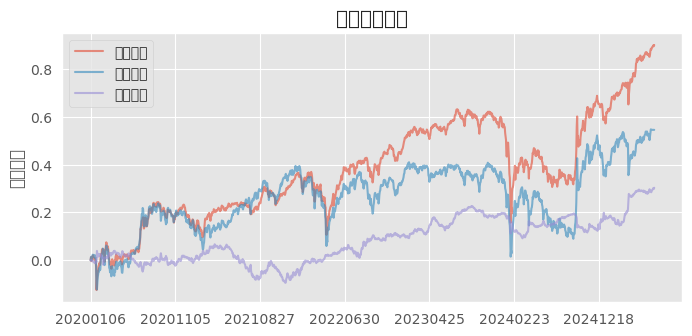

,指数收益,超额收益,策略收益
年化收益率,0.102,0.057,0.169
年化波动率,0.247,0.095,0.225
夏普率,0.415,0.597,0.752
最大回撤,-0.395,-0.161,-0.474
收益回撤比,0.259,0.353,0.357
胜率,0.535,0.483,0.559
盈亏比,0.935,1.192,0.915


In [85]:
result = ff.run(factor1 * ff.filter0, positions=100, period=1, fees=0)